In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
hybridsac_data = []
min_size = np.inf
for path in glob.glob('./examples/data/PendulumEnv/*/'):
    data = pickle.load(open(path + 'reward_data.pkl', 'rb'))
    if len(data) < min_size:
        min_size = len(data)
    hybridsac_data.append(data)

In [3]:
hybridsac_data = np.stack([data[:min_size] for data in hybridsac_data])

In [4]:
mean_hs_data = np.mean(hybridsac_data, axis=0)
std_hs_data  = np.std(hybridsac_data, axis=0)

In [5]:
benchmarksac_data = []
min_size = np.inf
for path in glob.glob('./benchmark_examples/data/PendulumEnv/*/'):
    data = pickle.load(open(path + 'reward_data.pkl', 'rb'))
    if len(data) < min_size:
        min_size = len(data)
    benchmarksac_data.append(data)



In [6]:
benchmarksac_data = np.stack([data[:min_size] for data in benchmarksac_data])

In [7]:
mean_bms_data = np.mean(benchmarksac_data, axis=0)
std_bms_data  = np.std(benchmarksac_data, axis=0)

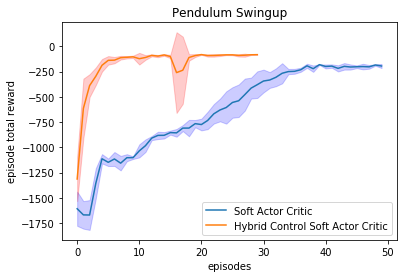

In [10]:
plt.plot(mean_bms_data, label='Soft Actor Critic')
plt.fill_between([i for i in range(len(mean_bms_data))], 
                mean_bms_data-std_bms_data*0.95, mean_bms_data+std_bms_data*0.95,
                alpha=0.2, color='b')

plt.plot(mean_hs_data, label='Hybrid Control Soft Actor Critic')
plt.fill_between([i for i in range(len(mean_hs_data))], 
                mean_hs_data-std_hs_data*0.95, mean_hs_data+std_hs_data*0.95,
                alpha=0.2, color='r')
plt.xlabel('episodes')
plt.ylabel('episode total reward')
plt.title('Pendulum Swingup')

plt.legend()

# plt.savefig('pend_swingup.png')

In [137]:
hybridsac_data = []
min_size = np.inf
for path in glob.glob('./examples/data/InvertedPendulumSwingupBulletEnv/*/'):
    data = pickle.load(open(path + 'reward_data.pkl', 'rb'))
    if len(data) < min_size:
        min_size = len(data)
    hybridsac_data.append(data)

In [138]:
hybridsac_data = np.stack([data[:min_size] for data in hybridsac_data])

In [139]:
mean_hs_data = np.mean(hybridsac_data, axis=0)
std_hs_data  = np.std(hybridsac_data, axis=0)

In [140]:
benchmarksac_data = []
min_size = np.inf
for path in glob.glob('./benchmark_examples/data/InvertedPendulumSwingupBulletEnv/*/'):
    data = pickle.load(open(path + 'reward_data.pkl', 'rb'))
    if len(data) < min_size:
        min_size = len(data)
    benchmarksac_data.append(data)


In [141]:
benchmarksac_data = np.stack([data[:min_size] for data in benchmarksac_data])

In [142]:
mean_bms_data = np.mean(benchmarksac_data, axis=0)
std_bms_data  = np.std(benchmarksac_data, axis=0)

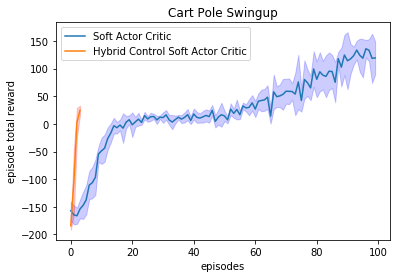

In [143]:
plt.plot(mean_bms_data, label='Soft Actor Critic')
plt.fill_between([i for i in range(len(mean_bms_data))], 
                mean_bms_data-std_bms_data*0.95, mean_bms_data+std_bms_data*0.95,
                alpha=0.2, color='b')

plt.plot(mean_hs_data, label='Hybrid Control Soft Actor Critic')
plt.fill_between([i for i in range(len(mean_hs_data))], 
                mean_hs_data-std_hs_data*0.95, mean_hs_data+std_hs_data*0.95,
                alpha=0.2, color='r')
plt.xlabel('episodes')
plt.ylabel('episode total reward')
plt.title('Cart Pole Swingup')

plt.legend()

# plt.savefig('lunar_lander.png')